# XGBoost for Sink Particles
> Created Jan. 2025 <br>
> Nikhil Bisht<br>

In [270]:
# standard system modules
import os, sys
os.environ["PATH"] += os.pathsep + "/home/nbisht/myapps/bin/"
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
import xgboost as xgb

import sklearn.metrics as skm

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.dict'

IMAGESIZE = 128

#In percentage
NTRAIN_percentage =  0.9
NVALID_percentage =  0.05
NTEST_percentage  =  0.10

#ALL_COLUMNS = ['Initial_Frame', 'Particle_id', 'X_i', 'Y_i', 'Z_i', 'Vx_i', 'Vy_i', 'Vz_i', 'Density_i', 'X_f', 'Y_f', 'Z_f', 'Vx_f', 'Vy_f', 'Vz_f', 'Density_f']
#FEATURES = ALL_COLUMNS[0:9]
#TARGET = ALL_COLUMNS[9:]

ALL_COLUMNS = ['Initial_Frame', 'Particle_id', 'X_i', 'Y_i', 'Z_i', 'X_f', 'Y_f', 'Z_f']
FEATURES = ALL_COLUMNS[0:5]
TARGET = ALL_COLUMNS[5:]

FRAMES = np.arange(40,60, 1)
FRAME_DIFF = 30

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load data

In [247]:
#get core stuff
df_core_pids =[]
with h5py.File(CORESET, 'r') as f:
    tm = f['track_manager']
    df_core_pids = tm['particle_ids'][()]

#get data and prepare sample
df_timeseries_core = pd.DataFrame([], columns=ALL_COLUMNS)
df_timeseries_noncore = pd.DataFrame([], columns=ALL_COLUMNS)
f =  h5py.File(DATAFILE, 'r')
for frame_num_index in range(len(FRAMES)):
    frame_num = FRAMES[frame_num_index]
    print(frame_num)
    temp_df_timeseries = pd.DataFrame([], columns=FEATURES)
    temp_final_df = pd.DataFrame([], columns=['Particle_id'])
    f_frame_ini = f[str(frame_num)]
    f_frame_fin = f[str(frame_num+FRAME_DIFF)]
    temp_df_timeseries['Initial_Frame'] = np.repeat(frame_num, len(f_frame_ini['Particle_id'][()]))
    temp_df_timeseries['Particle_id'] = f_frame_ini['Particle_id'][()]
    temp_df_timeseries['Particle_id'] = temp_df_timeseries['Particle_id'].astype('int32')
    temp_df_timeseries = temp_df_timeseries.set_index('Particle_id')
    temp_final_df['Particle_id'] = f_frame_fin['Particle_id'][()]
    temp_final_df['Particle_id'] = temp_final_df['Particle_id'].astype('int32')
    temp_final_df = temp_final_df.set_index('Particle_id')
    for cname in ['X', 'Y', 'Z']:
        temp_df_timeseries[cname+'_i'] = f_frame_ini[cname][()]
        temp_final_df[cname+'_f'] = f_frame_fin[cname][()]
    temp_df_timeseries = temp_df_timeseries.join(temp_final_df, on='Particle_id', how='inner')
    temp_df_timeseries_core = temp_df_timeseries.loc[df_core_pids]
    temp_df_timeseries_noncore = temp_df_timeseries.drop(df_core_pids)
    temp_df_timeseries_core = temp_df_timeseries_core.reset_index(names='Particle_id')
    temp_df_timeseries_noncore = temp_df_timeseries_noncore.reset_index(names='Particle_id')
    if frame_num_index == 0:
        df_timeseries_core = temp_df_timeseries_core
        df_timeseries_noncore = temp_df_timeseries_noncore
    else:
        df_timeseries_core = pd.concat([df_timeseries_core, temp_df_timeseries_core])
        df_timeseries_noncore = pd.concat([df_timeseries_noncore, temp_df_timeseries_noncore])

f.close()

print(len(df_core_pids))
print(len(df_timeseries_core))
df_timeseries_core.head(20)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
117364
2347280


,Particle_id,Initial_Frame,X_i,Y_i,Z_i,X_f,Y_f,Z_f
0,1405,40,0.561639,0.160418,0.938095,0.589335,0.167772,0.919246
1,1488,40,0.066252,0.213458,0.937764,0.017390,0.243816,0.925989
2,1489,40,0.076220,0.226310,0.942724,0.035887,0.259322,0.920143
3,1490,40,0.084780,0.228440,0.947606,0.037667,0.259022,0.920247
4,1531,40,0.557085,0.164256,0.967639,0.591734,0.168231,0.926531
5,1551,40,0.058797,0.210295,0.936420,0.020432,0.246717,0.927614
6,1552,40,0.069444,0.221795,0.940237,0.044771,0.252411,0.925480
7,1553,40,0.075663,0.234251,0.946715,0.031831,0.268330,0.928681
8,1555,40,0.094986,0.246785,0.957175,0.040666,0.289092,0.955389
9,1558,40,0.127268,0.244349,0.976523,0.072504,0.288868,0.962504


In [248]:
df_timeseries_core[df_timeseries_core['Particle_id'] == 1405]

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,X_f,Y_f,Z_f
0,1405,40,0.561639,0.160418,0.938095,0.589335,0.167772,0.919246
0,1405,41,0.563661,0.160761,0.936524,0.589908,0.168193,0.918673
0,1405,42,0.565226,0.161014,0.935352,0.590029,0.168290,0.918543
0,1405,43,0.565581,0.161072,0.935081,0.590426,0.168637,0.918098
0,1405,44,0.567288,0.161365,0.933723,0.590877,0.169118,0.917503
0,1405,45,0.568941,0.161624,0.932466,0.591278,0.169632,0.916883
0,1405,46,0.570152,0.161783,0.931642,0.591395,0.169793,0.916695
0,1405,47,0.570659,0.161845,0.931318,0.591667,0.170178,0.916253
0,1405,48,0.572326,0.162054,0.930302,0.592037,0.170748,0.915616
0,1405,49,0.573844,0.162278,0.929386,0.592394,0.171339,0.914971


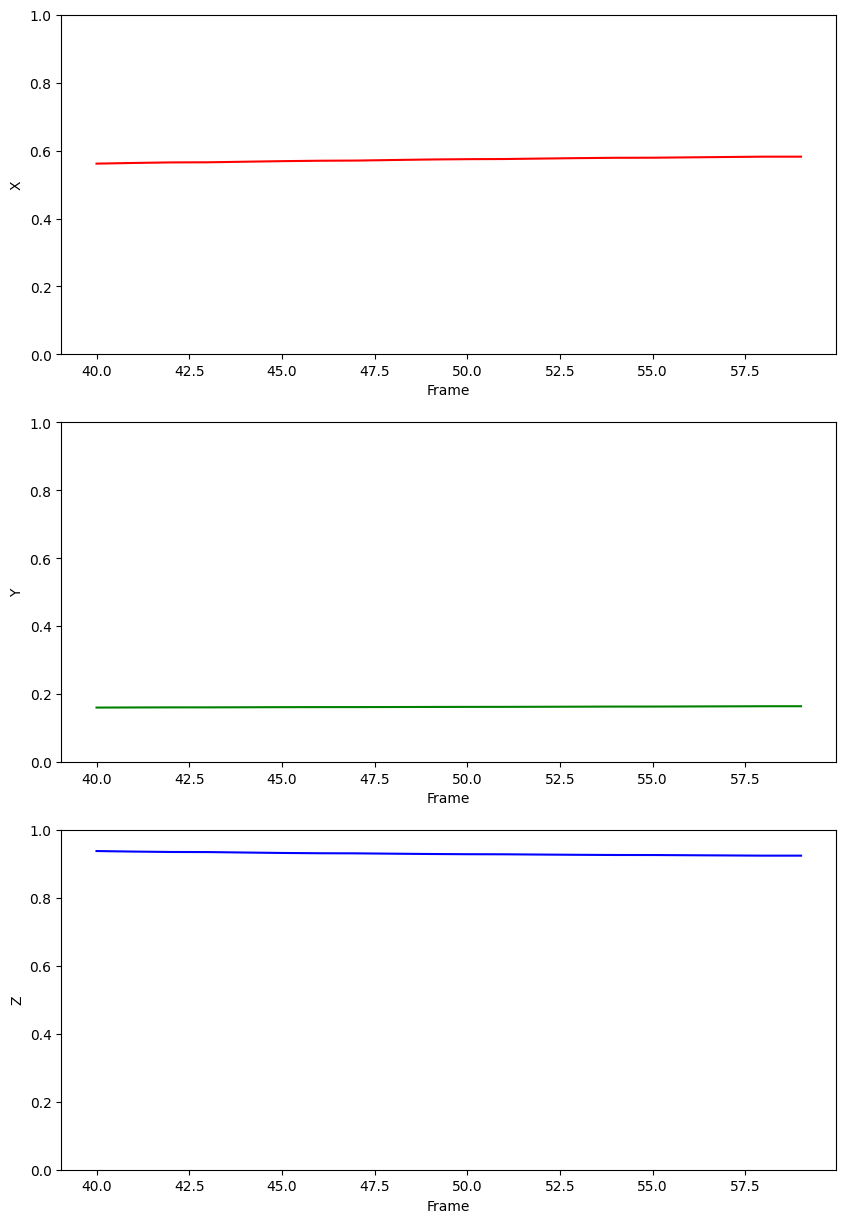

In [249]:
#Same Particle_ids across Initial_Frames
def get_track(df, particle_id):
    track_df = df[df['Particle_id'] == particle_id]
    xpos = track_df['X_i'].values
    ypos = track_df['Y_i'].values
    zpos = track_df['Z_i'].values
    frames = track_df['Initial_Frame'].values
    fig = plt.figure(figsize=(10, 15))
    ax = fig.add_subplot(311)
    ax.plot(frames, xpos, 'r')
    ax.set_xlabel('Frame')
    ax.set_ylabel('X')
    ax.set_ylim([0,1])
    ax = fig.add_subplot(312)
    ax.plot(frames, ypos, 'g')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Y')
    ax.set_ylim([0,1])
    ax = fig.add_subplot(313)
    ax.plot(frames, zpos, 'b')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Z')
    ax.set_ylim([0,1])
    plt.savefig('track_'+str(particle_id)+'.png')
    plt.show()

get_track(df_timeseries_core, 1405)

In [250]:
def plot_data(df, name = '', suppress = False, just_i = False):
    if just_i==True:
        fig = plt.figure(figsize=(4.5*len(FRAMES), 4.5))
        for frame_num_index in range(len(FRAMES)):
            df_this_frame = df[df['Initial_Frame']==FRAMES[frame_num_index]]
            ax = plt.subplot2grid((1,len(FRAMES)), (0,frame_num_index))
            ax.set_title(f'Frame: {FRAMES[frame_num_index]}', fontsize=18)
            ax.set_xlim(0, 1)
            ax.set_xlabel('X', fontsize=18)
            ax.set_ylim(0, 1)
            ax.set_ylabel('Y', fontsize=18)
            ax.scatter(df_this_frame['X_i'], df_this_frame['Y_i'], s=1e-2, color='red')
    else:
        fig = plt.figure(figsize=(4.5*len(FRAMES), 8))
        for frame_num_index in range(len(FRAMES)):
            df_this_frame = df[df['Initial_Frame']==FRAMES[frame_num_index]]
            ax = plt.subplot2grid((2,len(FRAMES)), (0,frame_num_index))
            ax.set_title(f'Frame: {FRAMES[frame_num_index]}', fontsize=18)
            ax.set_xlim(0, 1)
            ax.set_xlabel('X', fontsize=18)
            ax.set_ylim(0, 1)
            ax.set_ylabel('Y', fontsize=18)
            ax.scatter(df_this_frame['X_i'], df_this_frame['Y_i'], s=1e-4, color='red')

            ax = plt.subplot2grid((2,len(FRAMES)), (1,frame_num_index))
            ax.set_title(f'Frame: {FRAMES[frame_num_index]+FRAME_DIFF}', fontsize=18)
            ax.set_xlim(0, 1)
            ax.set_xlabel('X', fontsize=18)
            ax.set_ylim(0, 1)
            ax.set_ylabel('Y', fontsize=18)
            ax.scatter(df_this_frame['X_f'], df_this_frame['Y_f'], s=1e-4, color='royalblue')
        
    
    fig.tight_layout()
    plt.savefig('Core_Particles_'+name+'_All_Frames_Frame'+str(FRAMES[0])+'_to_Frame'+str(FRAMES[-1])+'.png')
    if not suppress:
        plt.show()

def plot_prediction(y_true,y_pred, append=''):
    fig = plt.figure(figsize=(12, 8))
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        ax.scatter(y_true[:,i], y_pred[:,i], c='crimson', s=1e-2)
        p1 = max(max(y_pred[:,i]), max(y_true[:,i]))
        p2 = min(min(y_pred[:,i]), min(y_true[:,i]))
        ax.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        ax.set_ylabel(TARGET[i])
        ax.set_xlim([-0.5,1.5])
        ax.set_ylim([-0.5,1.5])
    fig.tight_layout()
    plt.savefig('Core_Particles_All_Frames_Frame'+str(FRAMES[0])+'_to_Frame'+str(FRAMES[-1])+'_Prediction'+append+'.png')
    plt.show()

#plot_data(df_timeseries_core)

## Split data

In [260]:
def df_transform(df_test, shift, just_i = False):
    df = df_test.copy()
    df['X_i'] = df['X_i'].apply(lambda x: np.abs(x + shift[0]))
    df['Y_i'] = df['Y_i'].apply(lambda x: np.abs(x + shift[1]))
    df['Z_i'] = df['Z_i'].apply(lambda x: np.abs(x + shift[2]))
    if just_i:
        return df
    df['X_f'] = df['X_f'].apply(lambda x: np.abs(x + shift[0]))
    df['Y_f'] = df['Y_f'].apply(lambda x: np.abs(x + shift[1]))
    df['Z_f'] = df['Z_f'].apply(lambda x: np.abs(x + shift[2]))
    return df

def df_inverse_transform(df_test, shift, just_i = False):
    df = df_test.copy()
    if just_i:
        df['X_i'] = df['X_i'].apply(lambda x: np.abs(x - shift[0]))
        df['Y_i'] = df['Y_i'].apply(lambda x: np.abs(x - shift[1]))
        df['Z_i'] = df['Z_i'].apply(lambda x: np.abs(x - shift[2]))
    else:
        df['X_f'] = df['X_f'].apply(lambda x: np.abs(x - shift[0]))
        df['Y_f'] = df['Y_f'].apply(lambda x: np.abs(x - shift[1]))
        df['Z_f'] = df['Z_f'].apply(lambda x: np.abs(x - shift[2]))
    return df


def model_test(model_dic, test_df, test_y, bdry_condition, shift_array):
    df_temp = {}
    df_temp_y = {}
    y_pred_dic = {}
    for key in model_dic.keys():
        bdry = bdry_condition[key]
        test_df['condition_'+key] = np.where(((test_df['X_i'].between(bdry['x'][0],bdry['x'][1])) & (test_df['Y_i'].between(bdry['y'][0],bdry['y'][1])) & 
                                                (test_df['Z_i'].between(bdry['z'][0],bdry['z'][1]))), 1, 0)
        df_temp[key] = test_df[test_df['condition_'+key] == 1]
        df_temp_y[key] = test_y[test_df['condition_'+key] == 1]
        print(df_temp[key].index)
        print(df_temp_y[key].index)
        df_temp[key] = df_transform(df_temp[key], shift = shift_array[key], just_i = True)
        y_pred = model_dic[key].predict(df_temp[key][FEATURES])
        y_pred_df = pd.DataFrame({'X_f': y_pred[:, 0], 'Y_f': y_pred[:, 1], 'Z_f': y_pred[:, 2]})
        y_pred_dic[key] =  df_inverse_transform(y_pred_df, shift = shift_array[key])
        
    y_pred_all = pd.concat([y_pred_dic[key] for key in y_pred_dic.keys()])
    y_hat_all = pd.concat([df_temp_y[key] for key in df_temp_y.keys()])
    return y_pred_all, y_hat_all


In [275]:
X, y = df_timeseries_core[FEATURES], df_timeseries_core[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = NTEST_percentage,  random_state=seed)

#Split the data into octants o1 (0,0.5,0.5) to (0.5,1,1) clockwise to o8 (0,0,0) to (0.5,0.5,0.5)
bdry_condition = {'o1':{'x':[0,0.5],'y':[0.5,1],'z':[0.5,1]}, 'o2':{'x':[0.5,1],'y':[0.5,1],'z':[0.5,1]}, 'o3':{'x':[0.5,1],'y':[0,0.5],'z':[0.5,1]}, 'o4':{'x':[0,0.5],'y':[0,0.5],'z':[0.5,1]}, 
                    'o5':{'x':[0,0.5],'y':[0.5,1],'z':[0,0.5]}, 'o6':{'x':[0.5,1],'y':[0.5,1],'z':[0,0.5]}, 'o7':{'x':[0.5,1],'y':[0,0.5],'z':[0,0.5]}, 'o8':{'x':[0,0.5],'y':[0,0.5],'z':[0,0.5]}}
shift = 0.25
shift_array = {'o1':[+0.25,-0.25,-0.25], 'o2':[-0.25,-0.25,-0.25], 'o3':[-0.25,+0.25,-0.25], 'o4':[+0.25,+0.25,-0.25],
                'o5':[+0.25,-0.25,+0.25], 'o6':[-0.25,-0.25,+0.25], 'o7':[-0.25,+0.25,+0.25], 'o8':[+0.25,+0.25,+0.25]}
df_dic = {}
X_dic = {}
y_dic = {}
X_train_dic = {}
X_test_dic = {}
y_train_dic = {}
y_test_dic = {}
condn_indices = []
for key in bdry_condition.keys():
    bdry = bdry_condition[key]
    df_timeseries_core['condition_'+key] = np.where(((df_timeseries_core['X_i'].between(bdry['x'][0],bdry['x'][1])) & (df_timeseries_core['Y_i'].between(bdry['y'][0],bdry['y'][1])) & 
                                            (df_timeseries_core['Z_i'].between(bdry['z'][0],bdry['z'][1]))), 1, 0)
    df_dic[key] = df_timeseries_core[df_timeseries_core['condition_'+key] == 1]
    #plot_data(df_dic[key], name = 'all_'+key, suppress=True)
    df_dic[key] = df_transform(df_dic[key], shift = shift_array[key])
    #plot_data(df_dic[key], name = 'all_transformed_'+key, suppress=True)

    X_dic[key], y_dic[key] = df_dic[key][FEATURES], df_dic[key][TARGET]
    X_train_dic[key], X_test_dic[key], y_train_dic[key], y_test_dic[key] = train_test_split(X_dic[key], y_dic[key], test_size = NTEST_percentage,  random_state=seed)
    X_test_dic[key] =  df_inverse_transform_X(X_test_dic[key])
    y_test_dic[key] =  df_inverse_transform_Y(y_test_dic[key])

X_test_all = pd.concat([X_test_dic['o1'], X_test_dic['o2'], X_test_dic['o3'], X_test_dic['o4'], X_test_dic['o5'], X_test_dic['o6'], X_test_dic['o7'], X_test_dic['o8']])
y_test_all = pd.concat([y_test_dic['o1'], y_test_dic['o2'], y_test_dic['o3'], y_test_dic['o4'], y_test_dic['o5'], y_test_dic['o6'], y_test_dic['o7'], y_test_dic['o8']])

In [276]:
df_timeseries_core.head()

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,X_f,Y_f,Z_f,condition_o1,condition_o2,condition_o3,condition_o4,condition_o5,condition_o6,condition_o7,condition_o8
0,1405,40,0.561639,0.160418,0.938095,0.589335,0.167772,0.919246,0,0,1,0,0,0,0,0
1,1488,40,0.066252,0.213458,0.937764,0.017390,0.243816,0.925989,0,0,0,1,0,0,0,0
2,1489,40,0.076220,0.226310,0.942724,0.035887,0.259322,0.920143,0,0,0,1,0,0,0,0
3,1490,40,0.084780,0.228440,0.947606,0.037667,0.259022,0.920247,0,0,0,1,0,0,0,0
4,1531,40,0.557085,0.164256,0.967639,0.591734,0.168231,0.926531,0,0,1,0,0,0,0,0


## Train model
https://xgboost.readthedocs.io/en/stable/parameter.html

In [277]:
n_estimators    = 1000   #The number of trees in the ensemble, often increased until no further improvements are seen.
max_depth       = 7     #The maximum depth of each tree, often values are between 1 and 10.
eta             = 0.1  #The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
subsample       = 1/2   #The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
colsample_bytree= 1     #Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

#We will evaluate the model using the best practice of repeated k-fold cross-validation with 3 repeats and 10 folds.
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

periodic_models = {}
model_scores = {}
for key in bdry_condition.keys():
    periodic_models[key] = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=eta, subsample=subsample, colsample_bytree=colsample_bytree, device = 'cpu')
    # evaluate model
    model_scores[key] = cross_val_score(periodic_models[key], X_train_dic[key], y_train_dic[key], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.concatenate((np.absolute(model_scores['o1']), np.absolute(model_scores['o2']), np.absolute(model_scores['o3']), np.absolute(model_scores['o4']), np.absolute(model_scores['o5']), 
            np.absolute(model_scores['o6']), np.absolute(model_scores['o7']), np.absolute(model_scores['o8'])))
print('Mean MAE: %.3f (%.3f)' % (np.absolute(model_scores['o1']).mean(), np.absolute(model_scores['o1']).std()) )


In [278]:
for key in periodic_models.keys():
    print(len(X_train_dic[key]))
    periodic_models[key].fit(X_train_dic[key], y_train_dic[key])

607313


Index([54062, 57893, 58310, 93952, 44402, 48453, 26822, 43036, 49208, 51115,
       ...
       34136, 33068, 90422, 59221, 52255, 24870, 51277, 22905, 45675, 52834],
      dtype='int64', length=67480)
Index([54062, 57893, 58310, 93952, 44402, 48453, 26822, 43036, 49208, 51115,
       ...
       34136, 33068, 90422, 59221, 52255, 24870, 51277, 22905, 45675, 52834],
      dtype='int64', length=67480)
RMSE: 0.093882
R2: -18.559


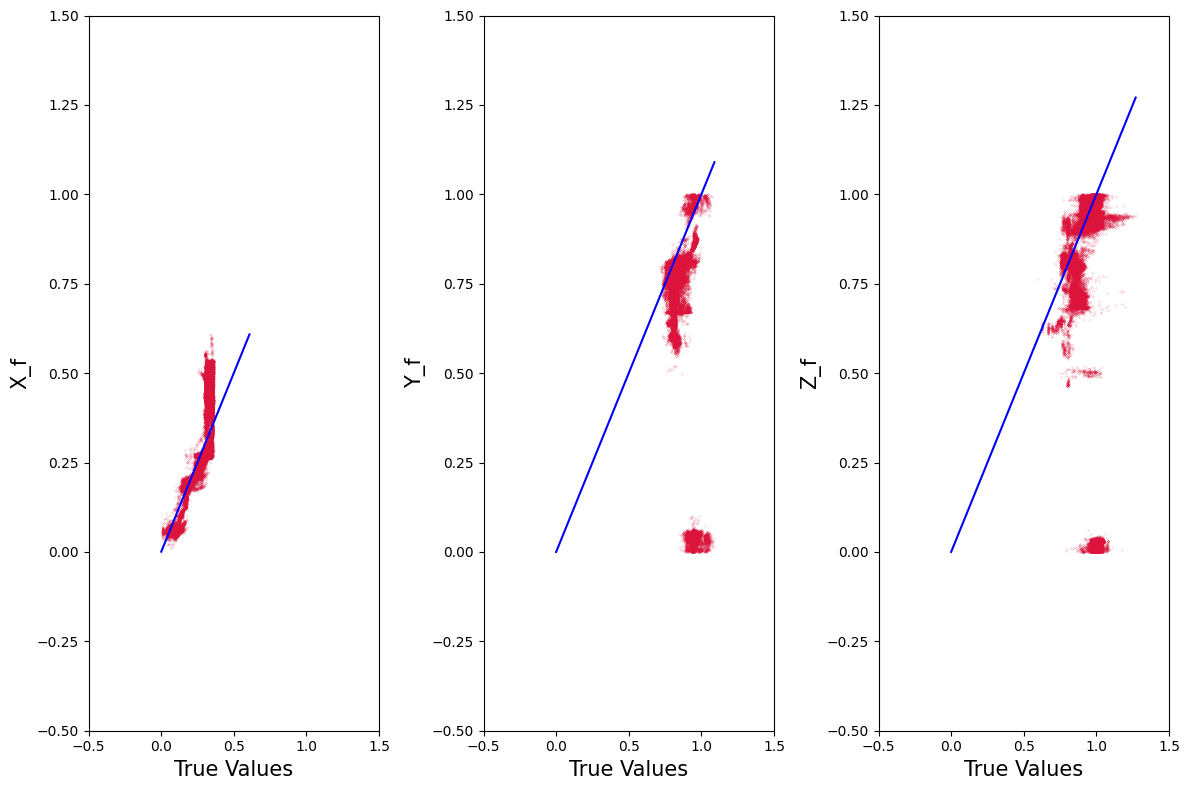

RMSE: 0.092918
R2: -21.302


In [279]:
ypred, yhat = model_test(periodic_models, X_test_all, y_test_all, bdry_condition, shift_array)
plot_prediction(ypred.to_numpy(),yhat.to_numpy(), append = '_Periodic_v1')
rmse = skm.mean_squared_error(ypred.to_numpy(), yhat.to_numpy())
r2 = skm.r2_score(ypred.to_numpy(),yhat.to_numpy())
print('RMSE: %.6f' % rmse)
print('R2: %.3f' % r2)

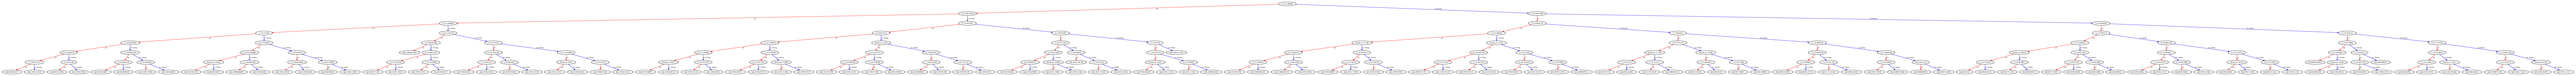

In [12]:
from io import BytesIO
import PIL
fig, (ax1,ax2) = plt.subplots(figsize=(210, 90), nrows=2, ncols=1)
g = xgb.to_graphviz(model_in, num_trees=0, ax=ax1)
s = BytesIO()
s.write(g.pipe(format="eps"))
s.seek(0)
img = np.array(PIL.Image.open(s))
ax1.imshow(img)
ax1.axis("off")
g = xgb.to_graphviz(model_edge, num_trees=0, ax=ax2)
s = BytesIO()
s.write(g.pipe(format="eps"))
s.seek(0)
img = np.array(PIL.Image.open(s))
ax2.imshow(img)
ax2.axis("off")
plt.savefig("Periodic_V0_model_in.png", dpi = 100)
plt.show()

## Stats
| Model 	| Loss 	        | n_estimators 	| max_depth 	| eta 	| subsample 	| lambda 	| alpha 	| Mean MAE 	| rmse 	| r2 	| remarks 	                                     |
|-------	|-------        |--------------	|-----------	|-----	|-----------	|--------	|-------	|----------	|------	|----	|---------	                                    |
|Simple V0	|squarederror   |1000           |  7         	|1e-2 	|1/30        	|   1    	|    1  	| 0.023  	|5e-3   |0.951	|Fails at periodic wrap                          |
|Simple V1	|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.019 	|4e-3  	|0.964	|Suprisingly better than V0                     |
|Simple V2	|squarederror   |1000          	|  7        	|1e-2   | 3/4        	|   1    	|    1  	| 0.019 	|4e-3  	|0.963	|Same as V1                                       |
|Periodic V0|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.004 	|4e-2  	|-0.882	|Worse than linear fit lol (wrap from 3. to .7)              |
|Periodic V1|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.007 	|3e-3  	|0.971	|Octant breakdown                 |